# Example Notebook

**You can download this Jupyter Notebook via the download button at the top of this page.**

In this Jupyter Notebook, we demonstrate the following operations using `sarxarray`:

- Load an interferogram stack in binary format into a `xarray.Dataset` object;
- Append latitude and longitude coordinates to the loaded stack;
- Create an Mean-Reflection-Map (MRM) of a subset of the interferogram stack;
- Apply common SAR processing steps to the interferogram stack;


## Setup

### Data preparation

We use a coregistered and georeferenced [Sentinel-1 interferogram stack over Amsterdam](https://figshare.com/ndownloader/files/41012180) as an example dataset. Please download the data and unzip it locally. 

### Environment setup
For the python environment setup, we assume you already installed SARXarray following the installation guide.

Some extra python dependencies are required to execute this notebook. You can install the extra python dependencies by:
```sh
pip install sarxarray[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running the `jupyter-lab` command in your command line:

```bash
jupyter-lab
```

Alternatively, you can also use Jupyter Notebook.

A new tab will be opened in your default browser to execute this notebook.

## Data loading

In [1]:
import numpy as np
from pathlib import Path
import sarxarray

We will load the interferogram stack, which has been coregistered and saved as binary files. We assume the shape and data type is known.

In [2]:
# Path to the interferogram dataset
path = Path('nl_amsterdam_s1_asc_t088')

# Make a list of interferograms to read
list_ifgs = [p for p in path.rglob('*_cint_srd.raw')]
list_ifgs.sort()

# Metadata of the stack, assume known.
shape=(2000, 4000)

# Define reading chunks
reading_chunks = (500,500)

In [3]:
# Check the list of interferograms
print(list_ifgs)

[PosixPath('nl_amsterdam_s1_asc_t088/20180920_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20180926_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181002_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181008_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181014_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181020_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181026_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181101_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181107_cint_srd.raw'), PosixPath('nl_amsterdam_s1_asc_t088/20181113_cint_srd.raw')]


Use `from_binary` to load the stack:

In [4]:
# Load complex data
stack = sarxarray.from_binary(list_ifgs, shape, dtype=np.complex64, chunks=reading_chunks)

print(stack)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>


## Append georeferenced coordinates

The `sarxarray` is implemented as an extension of `Xarray.Dataset`, which means we can modify the `stack` variable as a normal `Dataset` object. For example, we can append geo-coordinates to the loaded stack.

In [ ]:
# Geo-coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

In [6]:
# Load coordinates
lat = sarxarray.from_binary(
    f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks
)
lon = sarxarray.from_binary(
    f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks
)
stack = stack.assign_coords(
    lat=(("azimuth", "range"), lat.squeeze().lat.data),
    lon=(("azimuth", "range"), lon.squeeze().lon.data),
)

In [7]:
print(stack)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>


## Common SAR operations

Some common SAR operations are supported by SARXarray.

### Multi-Looking

We apply a `(1,2)` multi-look to the loaded stack. As a result the size of the output will be `(2000,2000)`. 

In [8]:
stack_multilook = stack.slcstack.multi_look((1,2))
print(stack_multilook)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 2000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 250, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 250, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 250, 1), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean


### Mean-Reflection-Map (MRM) 

In [9]:
mrm = stack_multilook.slcstack.mrm()
print(mrm)

<xarray.DataArray 'amplitude' (azimuth: 2000, range: 2000)>
dask.array<mean_agg-aggregate, shape=(2000, 2000), dtype=float32, chunksize=(500, 250), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
    lat      (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>


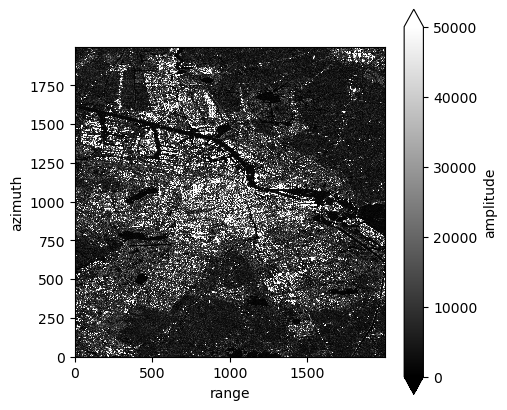

In [10]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((5,5))
ax.imshow(mrm)
im = mrm.plot(ax=ax, robust=True, cmap='gray')
im.set_clim([0, 50000])